<a href="https://colab.research.google.com/github/lefthandedcoder/plantclassifier/blob/main/plantclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download ryanpartridge01/wild-edible-plants/

 99% 1.69G/1.70G [00:07<00:00, 228MB/s]
100% 1.70G/1.70G [00:07<00:00, 230MB/s]


In [ ]:
! unzip wild-edible-plants.zip

In [7]:
#import the libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import os
from numpy.random import random

In [8]:
#Set the image size with are learning from
IMG_WIDTH, IMG_HEIGHT = 224,224

#Set the constants
TRAIN_DATA_DIR = '/content/dataset/resized'

EPOCHS = 25 #Higher for more time training model... diminishing returns
BATCH_SIZE = 256

# Machine Learning Model Filename
ML_MODEL_FILENAME = 'saved_model_mobilenet.h5'

In [9]:
def build_model():
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
    else:
        input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

    model = Sequential()
    
    pretrained_model= tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(224,224,3),
        pooling='avg',classes=35,
        weights='imagenet')

    for layer in pretrained_model.layers:
        layer.trainable=False
        
    model.add(pretrained_model)    
    model.add(Flatten())
    model.add(Dense(35, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [34]:
def train_model(model):
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      rotation_range=40,
      horizontal_flip=True,  
      fill_mode='nearest',
      validation_split=0.1) # set validation split

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=123,
        class_mode='categorical',
        subset='training') # set as training data
    
    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR, # same directory as training data
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=123,
        class_mode='categorical',
        subset='validation') # set as validation data
    
    filepath="/content/drive/MyDrive/weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // BATCH_SIZE,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // BATCH_SIZE,
        epochs = EPOCHS, callbacks=callbacks_list)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
    print('Validation accuracy:', val_acc)

    return model

In [40]:
def get_visualizations():

  # this is the augmentation configuration we will use for training
  train_datagen = ImageDataGenerator(
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      rotation_range=40,
      horizontal_flip=True,  
      fill_mode='nearest',  
      validation_split=0.1) # set validation split

  train_generator = train_datagen.flow_from_directory(
      TRAIN_DATA_DIR,
      target_size=(IMG_WIDTH, IMG_HEIGHT),
      batch_size=BATCH_SIZE,
      shuffle=False,
      class_mode='categorical',
      subset='training') # set as training data
  

  # Sample of images from dataset
  class_dict = train_generator.class_indices
  new_dict={}
  for key, value in class_dict.items():
      new_dict[value] = key        
  images,labels = next(train_generator) # sample batch from generator
  plt.figure(figsize = (10, 10))
  length = len(labels)
  if length < 25:   #show maximum of 25 images
      r = length
  else:
      r = 25
  for i in range(r):
      plt.subplot(5, 5, i + 1)
      image = (images[i]+1 )/2
      plt.imshow(image)
      index=np.argmax(labels[i])
      class_name = new_dict[index]
      plt.title(class_name, fontsize=16)
      plt.axis('off')
  plt.show()

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f52b1379a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [29]:
def get_bar():
  # Get bar chart of images per subdirectory
  import os
  import numpy as np
  import matplotlib.pyplot as plt

  plant_classes = []

  classes = ([name for name in os.listdir('/content/dataset/resized/')
              if os.path.isdir(os.path.join('/content/dataset/resized/', name))]) # get all directories 
  for plant in classes:
      contents = os.listdir(os.path.join(TRAIN_DATA_DIR, plant)) # get list of contents
      plant_classes.append([plant, len(contents)])
      
  labels, ys = zip(*plant_classes)
  xs = np.arange(len(labels)) 
  width = 1

  col = (np.random.random(), np.random.random(), np.random.random())

  fig = plt.figure()                                                               
  ax = fig.gca()  #get current axes
  ax.bar(xs, ys, color=col)

  ax.set_title("Distribution of Images Per Plant Class")
  ax.set_xticks(xs)
  ax.set_xticklabels(labels, rotation = 90, fontsize = 8)

  plt.savefig('distribution.png')

In [30]:
def main():
    myModel = None
    tf.keras.backend.clear_session()
    myModel = build_model()
    SVG(model_to_dot(myModel).create(prog='dot', format='svg'))
    myModel.summary()
    myModel = train_model(myModel)
    myModel.save(ML_MODEL_FILENAME)

In [35]:
main()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 35)                44835     
Total params: 2,302,819
Trainable params: 44,835
Non-trainable params: 2,257,984
_________________________________________________________________
Found 14885 images belonging to 35 classes.
Found 1641 images belonging to 35 classes.
Epoch 1/25
58/58 [==============================] - 258s 4s/step - loss: 2.2167 - accuracy: 0.4358 - val_loss: 1.3893 - val_accuracy: 0.6576

Epoch 00001: val_accuracy improved from -inf to 0.65755, saving model to /content/drive/MyDrive/weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
58/58 [==============================] - 235s 4s/step - loss: 1.1683 - accuracy: 0.7001 - val_loss: 1.0745 - val_accuracy: 0.7129

Epoch 00002: val_accuracy improved from 0.65755 to 0.71289, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 3/25
58/58 [==============================] - 235s 4s/step - loss: 0.9269 - accuracy: 0.7569 - val_loss: 0.9394 - val_accuracy: 0.7350

Epoch 00003: val_accuracy improved from 0.71289 to 0.73503, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 4/25
58/58 [==============================] - 235s 4s/step - loss: 0.8165 - accuracy: 0.7797 - val_loss: 0.8579 - val_accuracy: 0.7663

Epoch 00004: val_accuracy improved from 0.73503 to 0.76628, saving model to /content/drive/MyDrive/weights.best.hdf5
Epoch 5/25
58/58 [==============================] - 235s 4s/step - loss: 0.7389 - accuracy: 0.8027 - val_loss: 0.7871 - val_accuracy: 0.7865

Epoch 00005: val_accuracy improved from 0.76628 to 0.78646, saving model to /cont

KeyboardInterrupt: ignored

Found 14885 images belonging to 35 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

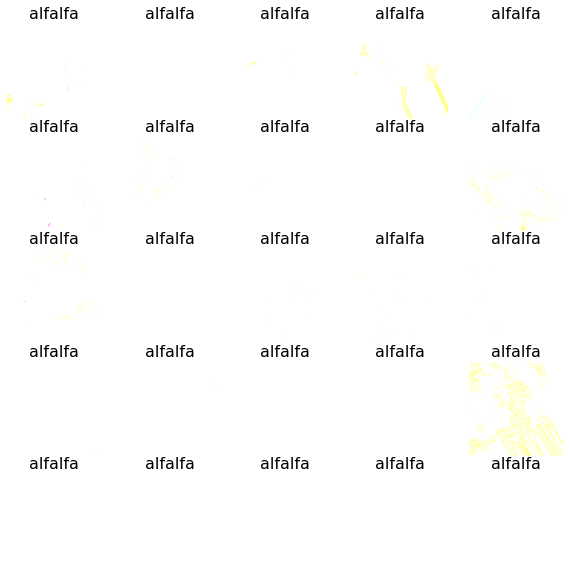

In [41]:
get_visualizations()

In [ ]:
get_bar()

In [ ]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing.image import image
import numpy as np
from google.colab import files
from IPython.display import Image 

plant_classes = []

classes = ([name for name in os.listdir('/content/dataset/resized/')
            if os.path.isdir(os.path.join('/content/dataset/resized/', name))]) # get all directories 
for plant in classes:
    contents = os.listdir(os.path.join(TRAIN_DATA_DIR, plant)) # get list of contents
    plant_classes.append([plant, len(contents)])

  
UPLOAD_FOLDER = "content"
myModel = load_model('/content/drive/MyDrive/weights.best.hdf5')

uploaded = files.upload()
#filename = next(iter(uploaded))
filename = '/content/Chive_Blossoms_-_panoramio.jpg'
Image(filename=filename, width = 224, height = 224)
test_image = image.load_img('/content/Chive_Blossoms_-_panoramio.jpg', target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
predictions = myModel.predict(test_image)
score = tf.nn.softmax(predictions[0])

print(
    "This is most likely an image of the wild edible plant {} with a {:.2f}% confidence."
    .format(plant_classes[np.argmax(score)][0], 100 * np.max(score))
)